In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Runing on {str(device)}")

# Define dataset paths
data_dir = "./animals10"
torch_dataset_path = "./animals10Dataset.pt"

# Define class names
class_names = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Load dataset from Torch tensor file
print("Loading dataset from Torch tensor file...")
data = torch.load(torch_dataset_path)
images, labels = data["images"], data["labels"]

dataset = TensorDataset(images, labels)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Runing on cuda
Loading dataset from Torch tensor file...
Train samples: 18325, Val samples: 3926, Test samples: 3928


In [3]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.to(device)

# Replace the final classification layer (model.fc) for 10 classes:
num_ftrs = model.fc.in_features  # typically 2048 for ResNet50
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

# ------------------------------------------------
# 5. Define Loss and Optimizer
# ------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust as needed

epochs = 10

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\11409/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.4MB/s]


In [5]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training/validation loss and accuracy curves in separate charts.
    """
    # Plot loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.show()

In [6]:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images_batch.size(0)
        
        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels_batch).sum().item()
        total += labels_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Track validation loss
            val_running_loss += loss.item() * images_batch.size(0)
            # Compute validation accuracy
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels_batch).sum().item()
            val_total += labels_batch.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")


Epoch [1/10] - Train Loss: 0.2523, Train Acc: 0.9401
Val Loss: 0.1075, Val Acc: 0.9720

Epoch [2/10] - Train Loss: 0.0571, Train Acc: 0.9840
Val Loss: 0.0859, Val Acc: 0.9766

Epoch [3/10] - Train Loss: 0.0317, Train Acc: 0.9911
Val Loss: 0.0950, Val Acc: 0.9753

Epoch [4/10] - Train Loss: 0.0234, Train Acc: 0.9935
Val Loss: 0.1068, Val Acc: 0.9710

Epoch [5/10] - Train Loss: 0.0261, Train Acc: 0.9918
Val Loss: 0.1220, Val Acc: 0.9710

Epoch [6/10] - Train Loss: 0.0208, Train Acc: 0.9936
Val Loss: 0.0968, Val Acc: 0.9766

Epoch [7/10] - Train Loss: 0.0166, Train Acc: 0.9954
Val Loss: 0.1242, Val Acc: 0.9682

Epoch [8/10] - Train Loss: 0.0152, Train Acc: 0.9960
Val Loss: 0.1156, Val Acc: 0.9725

Epoch [9/10] - Train Loss: 0.0094, Train Acc: 0.9975
Val Loss: 0.1471, Val Acc: 0.9664

Epoch [10/10] - Train Loss: 0.0180, Train Acc: 0.9949
Val Loss: 0.1336, Val Acc: 0.9712



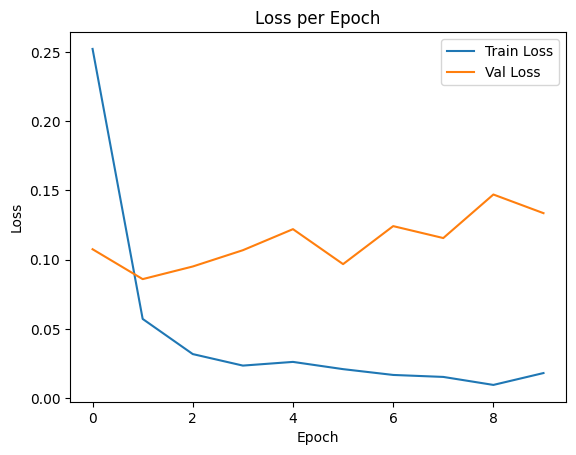

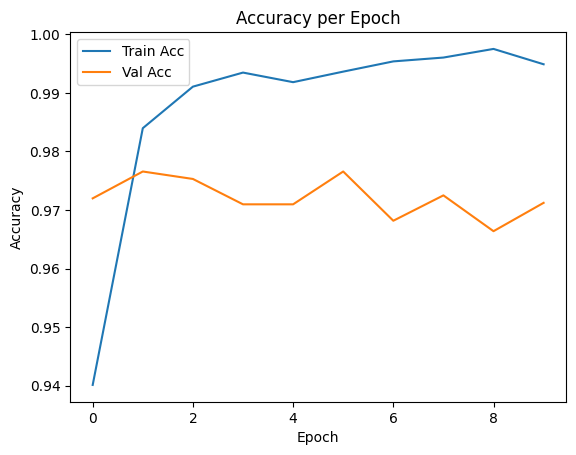

In [7]:
# Plot Loss and Accuracy
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)

In [8]:
# Testing

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.1119, Test Acc: 0.9743
